In [218]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')

In [220]:
paths = []
labels = []
for dirname, _, filenames in os.walk(r"C:\Users\tjyot\Downloads\archive"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [222]:
len(paths)

2800

In [224]:
paths[:5]

['C:\\Users\\tjyot\\Downloads\\archive\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'C:\\Users\\tjyot\\Downloads\\archive\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'C:\\Users\\tjyot\\Downloads\\archive\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'C:\\Users\\tjyot\\Downloads\\archive\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'C:\\Users\\tjyot\\Downloads\\archive\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

In [226]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [228]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,C:\Users\tjyot\Downloads\archive\TESS Toronto ...,angry
1,C:\Users\tjyot\Downloads\archive\TESS Toronto ...,angry
2,C:\Users\tjyot\Downloads\archive\TESS Toronto ...,angry
3,C:\Users\tjyot\Downloads\archive\TESS Toronto ...,angry
4,C:\Users\tjyot\Downloads\archive\TESS Toronto ...,angry


In [230]:
df['label'].value_counts() 

label
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

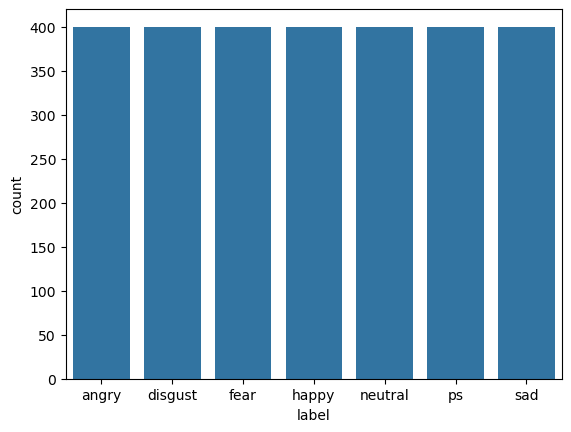

In [232]:
sns.countplot(data=df, x='label')

In [234]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(8,2))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)  # Displaying waveplot using librosa
    plt.show()

In [236]:
def spectogram(data, sr, emotion):
    x = librosa.stft(data)  # Applying short-time Fourier transform
    xdb = librosa.amplitude_to_db(abs(x))  # Converting amplitude to decibels
    plt.figure(figsize=(8,2))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')  # Displaying spectrogram
    plt.colorbar()

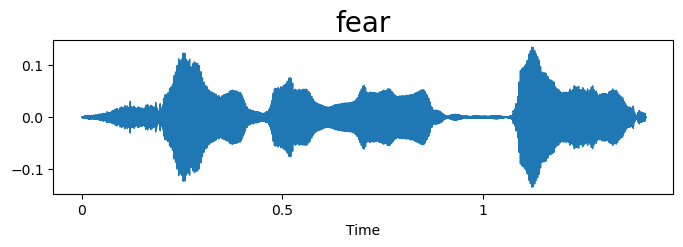

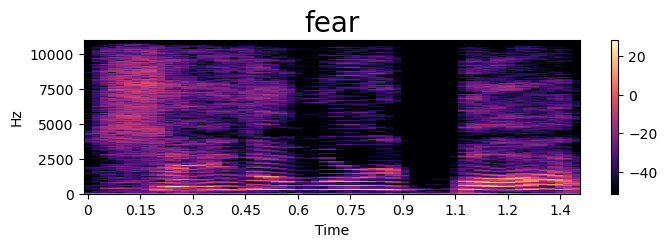

In [238]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[210]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

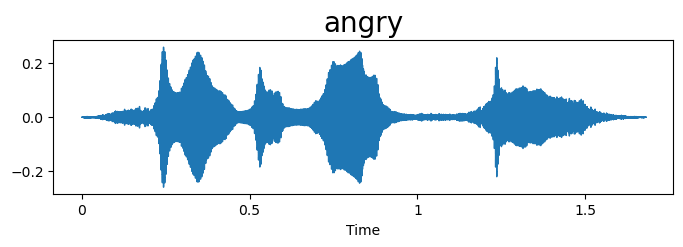

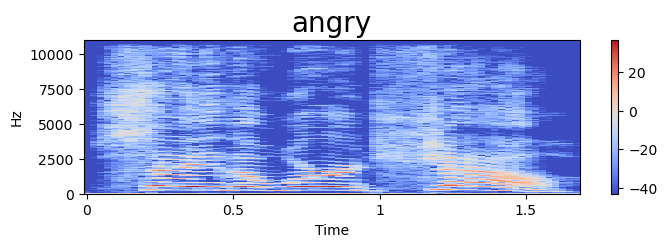

In [240]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[150]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

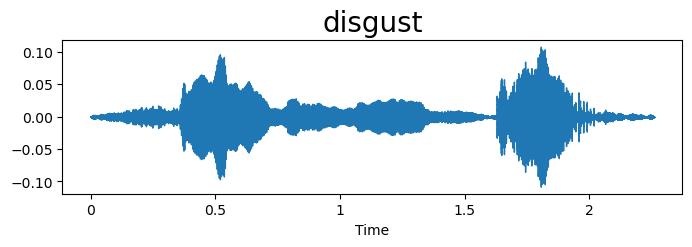

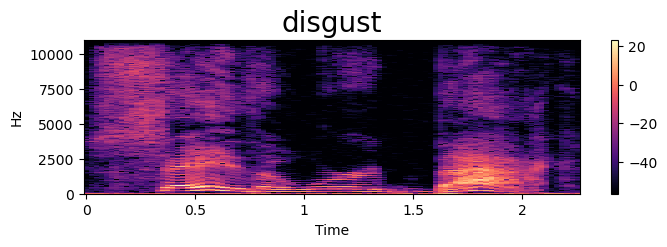

In [242]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[200]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

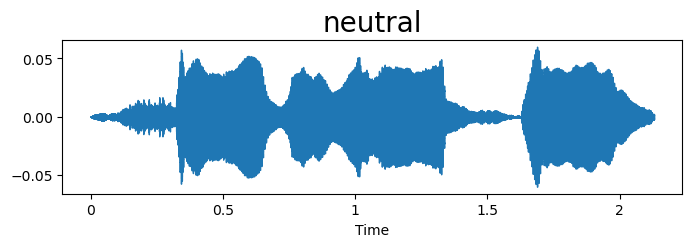

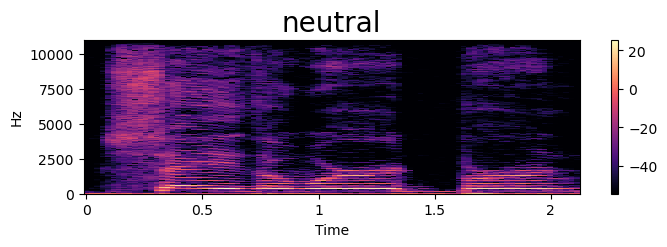

In [244]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[210]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

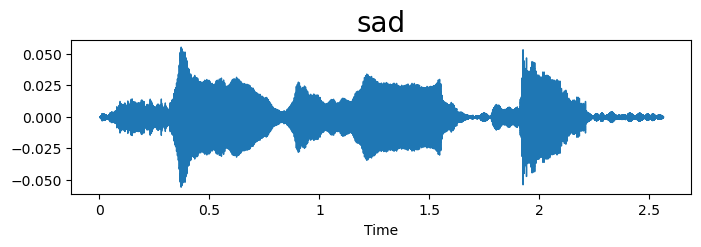

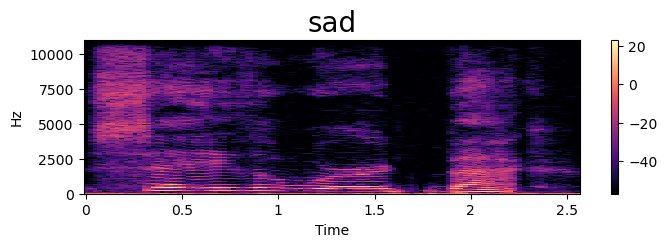

In [246]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

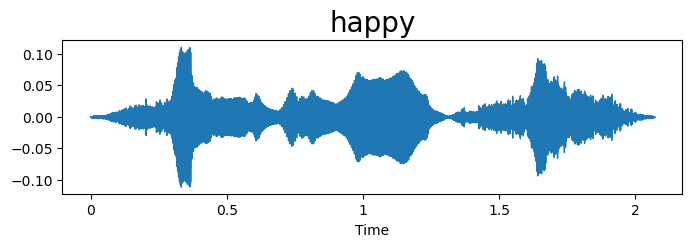

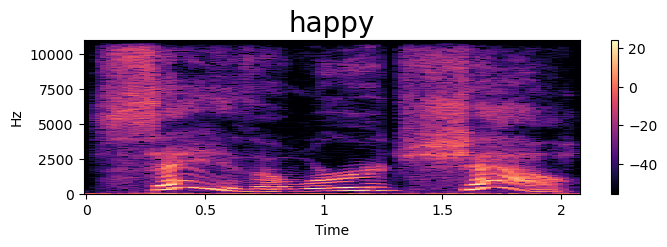

In [248]:
emotion = 'happy'
path = np.array(df['speech'][df['label'] == emotion])[150]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


In [250]:
################### # Data Augmentation Functions Adding more variations to the training data(tech: time_stretch, pitch_shift, noise injection,)
def augment_audio(data, sr):
    # Randomly apply one or more augmentations
    if np.random.random() < 0.5:
        data = librosa.effects.time_stretch(data, rate=np.random.uniform(0.8, 1.2))  
    # if np.random.random() < 0.5:          # Pitch Shifting: Modify the pitch of the audio.
    #     n_steps = np.random.uniform(-5, 5)     # Randomly shift pitch between -5 and +5 semitones
    #     data = librosa.effects.pitch_shift(data, sr, n_steps)
    if np.random.random() < 0.5:
        noise = np.random.randn(len(data))    #Noise Injection: Add random noise to the audio.
        data = data + 0.005 * noise
        
    if np.random.random() < 0.5:   # Time Shifting: Shift the audio signal in time.
        shift = np.random.randint(-sr // 10, sr // 10)  # Shift by up to 0.1 seconds
        data = np.roll(data, shift)  # Roll the array elements
        if shift > 0:
            data[:shift] = 0   # # Zero out the empty indices if rolling exceeds length
        else:
            data[shift:] = 0 
    return data

In [252]:
def extract_mfcc(filename, augment=False):
    y, sr = librosa.load(filename, duration=3, offset=0.5) # Load the audio file with a maximum duration of 3 seconds and an offset of 0.5 seconds.
    
    # If we want to apply audio augmentation (changing the audio slightly), do it here.
    if augment:
        y = augment_audio(y, sr)  # Call the augment_audio function to change the audio.
        
        # Check if the augmented audio data is a 1D array (like a single line of numbers).
        if y.ndim != 1:
            raise ValueError("Augmented audio data is not a 1D array.")  # Raise an error if the shape is wrong.
    
    # Extract the MFCC features from the audio. # MFCC (Mel-Frequency Cepstral Coefficients) are special features that help us understand the sound.
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)  # Calculate and average the MFCCs.
    
    return mfcc 

In [254]:
extract_mfcc(df['speech'][0])

array([-3.9698621e+02,  7.7440536e+01, -1.9592791e+01, -2.1666689e+01,
       -2.1127560e+00,  1.0075363e+01, -2.0366707e+01, -6.0924492e+00,
       -7.2122831e+00, -5.5736607e-01, -1.8325533e+00,  2.0210145e-01,
        7.2755075e-01,  1.3177377e+00,  2.8863375e+00,  2.8557906e+00,
       -4.7129216e+00, -4.4365110e+00, -1.6211596e+00, -1.0239839e+01,
       -7.5512629e+00, -1.7968802e+00, -7.0376525e+00,  9.4365845e+00,
        8.3558550e+00,  2.1712360e+01,  1.9216991e+01,  2.0348930e+01,
        1.3413366e+01,  8.3391724e+00,  3.9472219e-01,  5.1113148e+00,
        9.5687389e+00,  5.4548678e+00,  2.5099635e+00, -1.8239073e+00,
        4.8689618e+00,  9.3139229e+00,  2.0891502e+00, -1.9064913e+00],
      dtype=float32)

In [256]:
# Now we extract features from all the audio files in the 'speech' column of our DataFrame.
# We apply augmentation to some and keep the original audio for comparison.
X_mfcc_augmented = df['speech'].apply(lambda x: extract_mfcc(x, augment=True))  # Extract features with audio changes.
X_mfcc_original = df['speech'].apply(lambda x: extract_mfcc(x, augment=False))  # Extract features without changes.

In [258]:
X_mfcc_augmented

0       [-400.29376, 79.432945, -20.012371, -24.039331...
1       [-477.77942, 100.76463, -3.1481955, -36.190834...
2       [-429.79196, 46.12401, 1.5550478, -0.21709459,...
3       [-419.83862, 72.80277, -11.526895, -20.391947,...
4       [-441.13748, 69.31054, 7.8406296, 14.772851, 6...
                              ...                        
2795    [-308.5871350344851, 16.14873085590186, 12.611...
2796    [-608.57043, 96.20862, 35.57011, 12.663162, 28...
2797    [-556.6771, 86.21727, 27.288998, 18.112206, 22...
2798    [-578.8551, 107.73781, 32.53618, 12.129623, 22...
2799    [-314.25272971051595, 16.505312321659105, 14.2...
Name: speech, Length: 2800, dtype: object

In [260]:
X_mfcc_original

0       [-396.9862, 77.44054, -19.59279, -21.666689, -...
1       [-465.73267, 98.77373, 0.6560086, -32.74544, -...
2       [-429.79196, 46.12401, 1.5550478, -0.21709459,...
3       [-403.46118, 76.32369, -12.531775, -22.288858,...
4       [-434.05756, 77.4455, 10.865501, 16.092943, 8....
                              ...                        
2795    [-553.2201, 89.83577, 27.215466, 16.407124, 19...
2796    [-589.23676, 96.20407, 36.96118, 15.014446, 28...
2797    [-533.41815, 85.43242, 27.791998, 19.307178, 2...
2798    [-548.6142, 110.16424, 31.91024, 12.572518, 22...
2799    [-549.2962, 102.374565, 32.268833, 26.261614, ...
Name: speech, Length: 2800, dtype: object

In [262]:
X_mfcc_augmented.shape, X_mfcc_augmented.shape

((2800,), (2800,))

In [264]:
# Combine augmented and original MFCC features into one dataset.
# This helps us use both types of data (original and changed) for training our model.
X_combined = pd.concat([X_mfcc_augmented, X_mfcc_original], axis=0)  # Concatenate along rows (axis=0).
X = np.array([x for x in X_combined])  # Convert the combined features into a NumPy array for easier processing.
X = np.expand_dims(X, -1)  # Add an extra dimension to make the shape compatible with the LSTM model.
X.shape

(5600, 40, 1)

In [266]:
# Combine original and augmented labels & # Encoding the labels (emotion classes) into one-hot encoded format
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_combined = pd.concat([df['label'], df['label']], axis=0).to_numpy()  # Convert to NumPy array
# Fit the OneHotEncoder to our combined labels and transform them into a one-hot encoded format.
# One-hot encoding turns labels into binary format, which is easier for the model to understand.
y = enc.fit_transform(y_combined[:, np.newaxis]).toarray()
y, y.shape

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 (5600, 7))

In [268]:
############## Creating/Building LSTM model for Speech Emotion Recognition
# Import the necessary libraries for building the LSTM model.
from keras.models import Sequential  # Import the Sequential model type.
from keras.layers import Dense, LSTM, Dropout  # Import layers for the model.

# Build the LSTM model using a sequential approach, layer by layer.
model = Sequential([  
    # First LSTM layer with 256 units (neurons).
    # 'return_sequences=False' means the output will be the last output in the sequence.
    # 'input_shape=(40,1)' specifies that the input data has 40 features and 1 time step.
    LSTM(256, return_sequences=False, input_shape=(40,1)),  
    
    # First dense (fully connected) layer with 128 units and ReLU activation function.
    # ReLU helps the model learn complex patterns by allowing it to output zero for negative inputs.
    Dense(128, activation='relu'),  
    
    # Second dense layer with 64 units and ReLU activation.
    Dense(64, activation='relu'),   
    
    # Third dense layer with 64 units and ReLU activation.
    Dense(64, activation='relu'),  
    
    # Dropout layer to prevent overfitting by randomly setting 20% of the neurons to zero during training.
    Dropout(0.2),  
    
    # Fourth dense layer with 32 units and ReLU activation.
    Dense(32, activation='relu'),  
    
    # Another dropout layer to further help with regularization, reducing overfitting.
    Dropout(0.1),  
    
    # Final output layer with 7 units and softmax activation function.
    # Softmax converts the output to probabilities for 7 emotion classes (e.g., happy, sad, angry).
    Dense(7, activation='softmax')  
])

# Compile the model by specifying the loss function, optimizer, and metrics to track.
# 'categorical_crossentropy' is used for multi-class classification problems.
# 'adam' is a popular optimizer that adjusts the learning rate during training.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  

In [270]:
model.summary()  

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                       │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 311,815 (1.19 MB)

 Trainable params: 311,815 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [272]:
# IMPORT LIBRARIES TO MONITOR AND CONTROL TRAINING
from keras.callbacks import ModelCheckpoint, EarlyStopping  # Import tools to control model training and save progress.
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ModelCheckpoint: Save the model during training whenever it improves.
checkpoint = ModelCheckpoint("mymodel.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False)

# EarlyStopping: Stop training early if the validation accuracy doesn't improve.
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

# Train the model and use the callbacks for monitoring:
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=64, 
                    callbacks=[checkpoint, early])

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4058 - loss: 1.4739
Epoch 1: val_accuracy improved from -inf to 0.81138, saving model to mymodel.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.4087 - loss: 1.4671 - val_accuracy: 0.8114 - val_loss: 0.5647
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8356 - loss: 0.4711
Epoch 2: val_accuracy improved from 0.81138 to 0.93638, saving model to mymodel.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.8362 - loss: 0.4696 - val_accuracy: 0.9364 - val_loss: 0.1944
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9275 - loss: 0.2129
Epoch 3: val_accuracy did not improve from 0.93638
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9275 - loss: 0.2128 - val_accuracy: 0.9353 - val_loss: 0.1683
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9259 - loss: 0.2230
Epoch 4: val_accuracy improved from 0.93638 to 0.94643, saving model to mymodel.keras
56

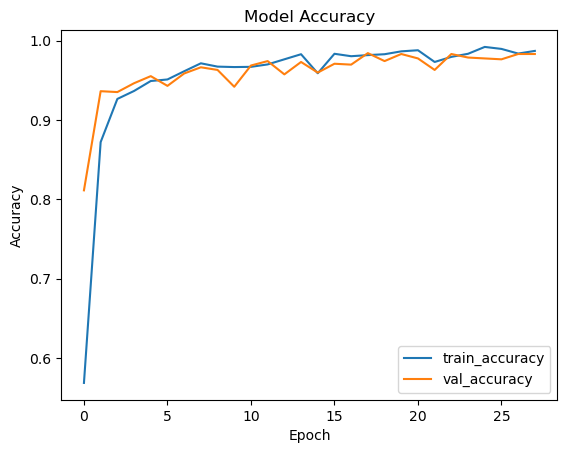

In [274]:
# Plotting the training and validation accuracy across epochs
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()